<a href="https://colab.research.google.com/github/nguyenvuong1309/Do-an-lap-trinh-an-toan/blob/main/BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import pandas as pd
from numpy import zeros, newaxis
import numpy as np
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional,Activation
import matplotlib.pyplot as plt
import csv


In [3]:
csv_file_path = '/content/drive/MyDrive/Colab/dataset/text_dataset.csv'
df = pd.read_csv(csv_file_path,sep=",")

In [4]:
dataset = df

In [5]:
print(dataset.head())

   Index                                                  1  label
0      0  1 150200/dirent_uri.c memset 405\nconst char *...      0
1      1  2 79848/CWE134_Uncontrolled_Format_String__cha...      0
2      2  3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...      0
3      3  4 151133/utils.c strcmp 737\nint avformat_open...      0
4      4  5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...     32


In [6]:
dataset = dataset[['1','label']]
dataset.head()

,1,label
0,1 150200/dirent_uri.c memset 405\nconst char *...,0
1,2 79848/CWE134_Uncontrolled_Format_String__cha...,0
2,3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...,0
3,4 151133/utils.c strcmp 737\nint avformat_open...,0
4,5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...,32


In [7]:
print(dataset['label'].unique())
print(len(dataset['label'].unique()))

[ 0 32  4 10 20 36  3  1 12 25 15 34 16 11  2 14 35 38  9 29  7 18 37 21
 22 23  5  8 17 31 39 33 28 30 19 40 26 13 24 27  6]
41


In [8]:
# train_dataset = dataset[0:int(len(dataset) * 0.8)]
# test_dataset =  dataset[int(len(dataset) * 0.8) :]
train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()
for i in range(41):
  temp_train = dataset[dataset['label'] == i][:int(0.8 * (dataset[dataset['label'] == i].shape[0]))]
  train_dataset = pd.concat([temp_train, train_dataset], axis=0, ignore_index=True)
  temp_test = dataset[dataset['label'] == i][int(0.8 * (dataset[dataset['label'] == i].shape[0])) : int((dataset[dataset['label'] == 0].shape[0]))]
  test_dataset = pd.concat([temp_test, test_dataset], axis=0, ignore_index=True)

print(train_dataset['label'].value_counts())
print(test_dataset['label'].value_counts())
train_dataset = train_dataset.sample(frac = 1)
test_dataset = test_dataset.sample(frac = 1)


0     109816
3      14708
20      4164
15      3181
4       2814
10      1511
2       1350
1       1155
12       729
14       632
32       486
36       336
34       334
29       332
18       260
9        228
25       228
17       208
16       167
5        156
11       150
35       147
33       142
8        113
39        76
31        72
28        68
23        52
22        48
7         47
37        43
27        36
21        34
19        33
30        29
26        26
13        24
38        16
6         12
40        12
24        11
Name: label, dtype: int64
0     27455
3      3677
20     1042
15      796
4       704
10      378
2       338
1       289
12      183
14      158
32      122
36       84
34       84
29       83
18       65
25       58
9        57
17       52
16       42
5        39
11       38
35       37
33       36
8        29
39       20
28       18
31       18
22       13
23       13
7        12
37       11
19        9
21        9
27        9
30        8
26        7
13       

In [9]:
#<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>
text_data = train_dataset['1'].values
tensor = tf.data.Dataset.from_tensor_slices(text_data)

In [10]:
tensor

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [11]:
train_dataset_numpy = np.array(train_dataset)

In [12]:
print(train_dataset_numpy[:3])

[['93698 149944/gimpdialogfactory.c pthread_mutex_unlock 226\nvoid *stonesoup_calc_data (void *data) 293\nstruct stonesoup_queue * ssQ ; 295\nssQ = get_instance ( NULL ); 309\nstruct stonesoup_queue *get_instance (char* file2) 258\nstatic struct stonesoup_queue * ssQ = NULL ; 259\nif ( ssQ == NULL )  263\nssQ = ( struct stonesoup_queue * ) calloc ( 1 , sizeof ( struct stonesoup_queue ) ); 267\nssQ -> size = 0; 271\nssQ -> capacity = 30; 272\nssQ -> head = NULL; 273\nssQ -> tail = NULL; 274\nreturn ssQ ; 278\nenqueue ( ssQ , - 1 ); 317\nint enqueue(struct stonesoup_queue *ssQ, int data) 207\nif ( ssQ != NULL )  209\nstruct stonesoup_list * elem = malloc ( sizeof ( struct stonesoup_list ) ) ; 210\nelem -> next = NULL; 215\nelem -> previous = ssQ -> tail; 216\nelem -> data = data; 217\nif ( ssQ -> tail != NULL )  218\nssQ -> tail -> next = elem; 219\nssQ -> tail = elem; 221\nssQ -> size ++; 222\nif ( ssQ -> head == NULL )  223\nssQ -> head = elem; 224\npthread_mutex_unlock ( & ( ssQ -> lo

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [14]:
train_dataset = train_dataset.sample(frac=1, replace=True, random_state=1)
test_dataset = test_dataset.sample(frac=1, replace=True, random_state=1)

In [15]:
print(train_dataset.shape)

(143986, 2)


In [16]:
len_dataset = int(train_dataset.shape[0])
x = np.array([i for i in range(41)])
y = np.array([])
for i in range(41):
  number = int(train_dataset[train_dataset['label'] == i].shape[0])
  y = np.insert(y,len(y),number)


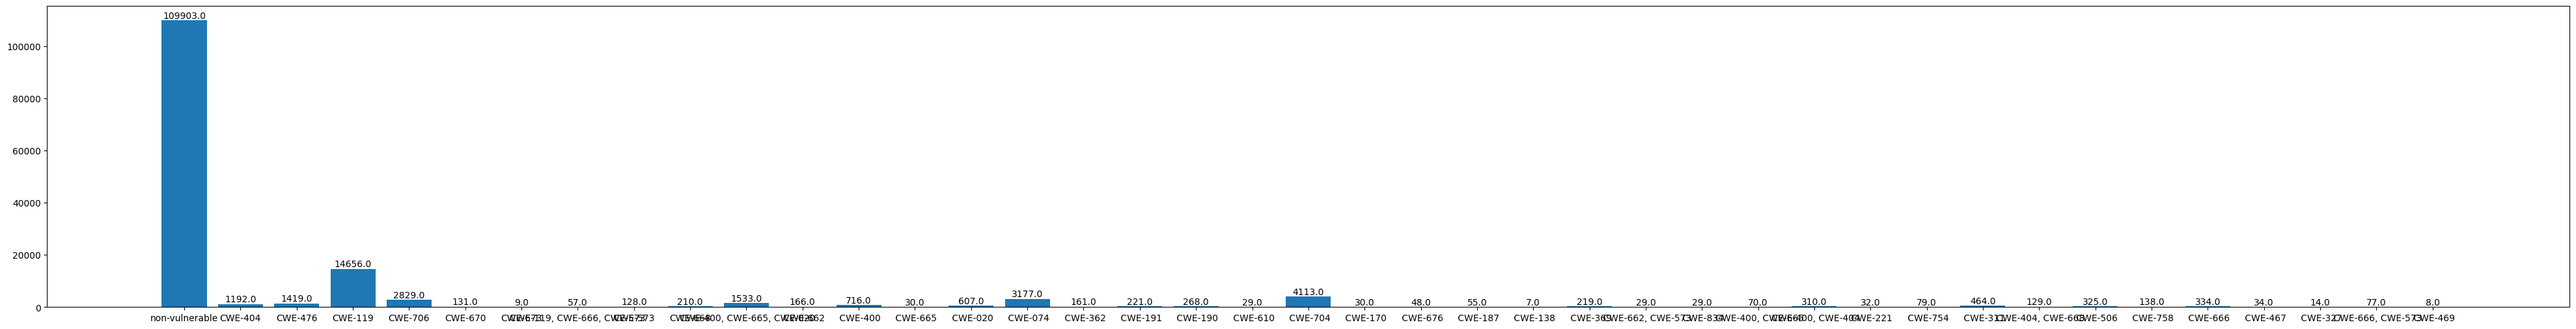

In [17]:
x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))

# Plot the bar chart
bars = ax.bar(x_cwe, y, label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

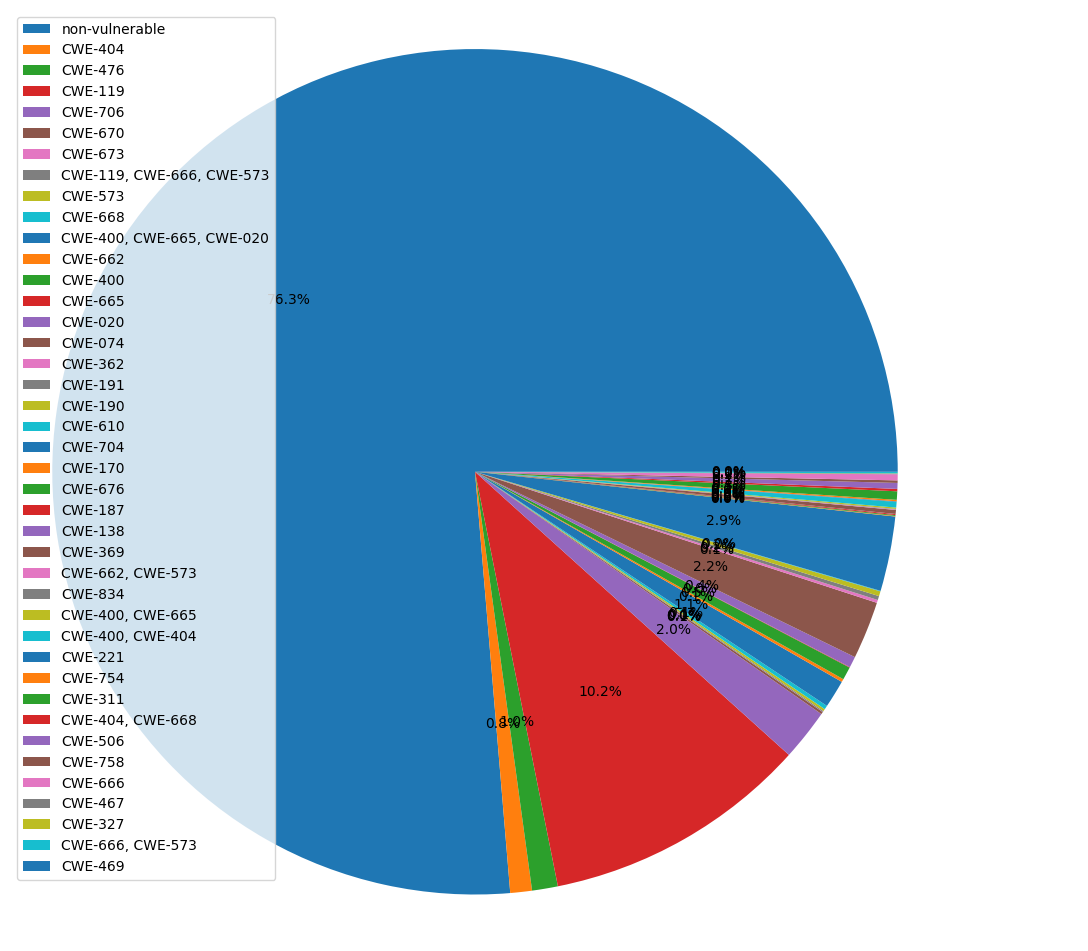

In [18]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample data
x_cwe = ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
# Count occurrences of each CWE
cwe_counter = Counter(x_cwe)
cwe_values = list(cwe_counter.values())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the pie chart
wedges, texts, autotexts = ax.pie(y, labels=cwe_counter.keys(), autopct='%1.1f%%', textprops=dict(color="w"))

# Add percentage annotations
for autotext in autotexts:
    autotext.set_color('black')

# Set the aspect ratio to be equal, ensuring the pie is drawn as a circle
ax.axis('equal')
plt.legend()

# Show the plot
plt.show()


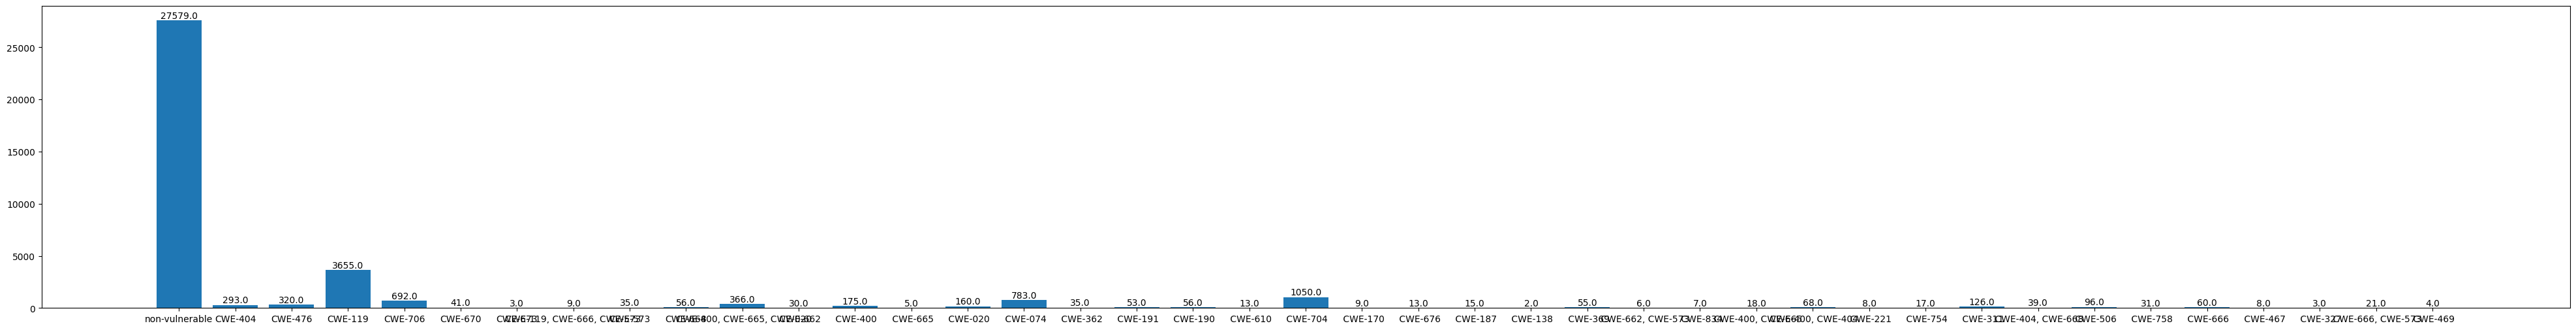

In [19]:
len_test_dataset = int(test_dataset.shape[0])
y_test_dataset = np.array([])
for i in range(41):
  number = int(test_dataset[test_dataset['label'] == i].shape[0])
  y_test_dataset = np.insert(y_test_dataset,len(y_test_dataset),number)

x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))
# Plot the bar chart
bars = ax.bar(x_cwe, y_test_dataset, label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

In [20]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tensor)

In [21]:
train_dataset['1']

123267    116929 149425/dfa.c xmalloc 2190\nvoid dfacomp...
19106     21404 62539/CWE121_Stack_Based_Buffer_Overflow...
51451     22774 69805/CWE122_Heap_Based_Buffer_Overflow_...
135617    133107 88445/CWE195_Signed_to_Unsigned_Convers...
42543     11009 80279/CWE134_Uncontrolled_Format_String_...
                                ...                        
4059      52264 87692/CWE195_Signed_to_Unsigned_Conversi...
115559    106868 89529/CWE226_Sensitive_Information_Uncl...
125593    119997 78442/CWE127_Buffer_Underread__new_char...
126405    121103 77944/CWE127_Buffer_Underread__malloc_c...
104029    91790 75791/CWE126_Buffer_Overread__CWE129_lis...
Name: 1, Length: 143986, dtype: object

In [22]:
train_dataset

,1,label
123267,116929 149425/dfa.c xmalloc 2190\nvoid dfacomp...,0
19106,21404 62539/CWE121_Stack_Based_Buffer_Overflow...,3
51451,22774 69805/CWE122_Heap_Based_Buffer_Overflow_...,0
135617,133107 88445/CWE195_Signed_to_Unsigned_Convers...,0
42543,11009 80279/CWE134_Uncontrolled_Format_String_...,0
...,...,...
4059,52264 87692/CWE195_Signed_to_Unsigned_Conversi...,20
115559,106868 89529/CWE226_Sensitive_Information_Uncl...,0
125593,119997 78442/CWE127_Buffer_Underread__new_char...,0
126405,121103 77944/CWE127_Buffer_Underread__malloc_c...,0


In [23]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '0', 'if', 'data', '1', 'char', 'void', 'i', 'd', 's',
       'service', 'sizeof', 'int', '100', 'recvresult', '2', 'static',
       'datalen', 'null'], dtype='<U559')

In [24]:
# example = [[' /CWE_Heap_Based_Buffer_Overflow__cpp_CWE_char_snprintf_.cpp memset \nvoid bad() \nchar * data ; \ndata = new char [  ]; \nif ( GLOBAL_CONST_TRUE )  \nmemset ( data , \'A\' ,  -  ); \ndata [  -  ] = \'\\\'; \nSNPRINTF ( dest , strlen ( data ) , "%s" , data ); \nprintLine ( data ); \nvoid printLine (const char * line) \nif ( line != NULL )  \nprintf ( "%s\\n" , line ); \ndelete [ ] data \n\n'],
#  [' /CWE_Trapdoor__ip_based_logic_.c send \nvoid CWE_Trapdoor__ip_based_logic__bad() \nWSADATA wsaData ; \nstruct sockaddr_in service , acceptService ; \nif ( WSAStartup ( MAKEWORD (  ,  ) , & wsaData ) != NO_ERROR )  \nlistenSocket = socket ( AF_INET , SOCK_STREAM , IPPROTO_TCP ); \nif ( listenSocket == INVALID_SOCKET )  \nmemset ( & service ,  , sizeof ( service ) ); \nservice . sin_family = AF_INET; \nservice . sin_addr . s_addr = INADDR_ANY; \nservice . sin_port = htons (  ); \nif ( bind ( listenSocket , ( struct sockaddr * ) & service , sizeof ( service ) ) == SOCKET_ERROR )  \nif ( listen ( listenSocket ,  ) == SOCKET_ERROR )  \nacceptSocket = accept ( listenSocket , NULL , NULL ); \nif ( acceptSocket == SOCKET_ERROR )  \nif ( getsockname ( acceptSocket , ( struct sockaddr * ) & acceptService , & acceptServiceLen ) == -  )  \nif ( strcmp ( "..." , inet_ntoa ( acceptService . sin_addr ) ) ==  )  \nif ( send ( acceptSocket , ADMIN_MESSAGE , strlen ( ADMIN_MESSAGE ) ,  ) == SOCKET_ERROR )  \nif ( send ( acceptSocket , DEFAULT_MESSAGE , strlen ( DEFAULT_MESSAGE ) ,  ) == SOCKET_ERROR )  \nwhile (  )  \n\n'],
#  [' /CWE_OS_Command_Injection__char_console_wspawnl_.c strlen \nvoid CWE_OS_Command_Injection__char_console_wspawnl__bad() \nchar * data ; \nchar dataBuffer [  ] = "" ; \ndata = dataBuffer; \nif ( staticFive ==  )  \nsize_t dataLen = strlen ( data ) ; \nif (  - dataLen >  )  \nif ( fgets ( data + dataLen , ( int ) (  - dataLen ) , stdin ) != NULL )  \ndataLen = strlen ( data ); \nif ( dataLen >  && data [ dataLen -  ] == \'\\n\' )  \ndata [ dataLen -  ] = \'\\\'; \n\n']
#            ]

In [25]:
# encoded_example = encoder(example)[:3].numpy()
# encoded_example

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
X_train = train_dataset['1']
y_train = train_dataset['label']
y_train = tf.keras.utils.to_categorical(y_train, num_classes=41)

In [29]:
print(X_train.shape)
print(y_train.shape)

(143986,)
(143986, 41)


In [30]:
history = model.fit(X_train,y_train, epochs=1,
                    # validation_data=test_dataset,
                    # validation_steps=30
                    )

4500/4500 [==============================] - 577s 124ms/step - loss: 0.4298 - accuracy: 0.9110


In [31]:
X_test = test_dataset['1']
y_test = test_dataset['label']
y_test = tf.keras.utils.to_categorical(y_test, num_classes=41)

In [32]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1126/1126 [==============================] - 39s 32ms/step - loss: 0.1078 - accuracy: 0.9736
Test Loss: 0.10784547030925751
Test Accuracy: 0.9736498594284058


In [33]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)
print(y_test.shape)
print(y_test)

1126/1126 [==============================] - 37s 31ms/step
(36015, 41)
[[9.98743117e-01 2.53558937e-05 5.51368692e-04 ... 8.70179040e-09
  1.28414977e-05 1.38871865e-08]
 [9.99937177e-01 1.19717424e-06 1.17973559e-05 ... 4.39567722e-11
  2.34479046e-07 7.78299439e-11]
 [9.95595276e-01 1.27687263e-05 6.74966839e-04 ... 5.34361675e-07
  8.25638708e-05 2.89233071e-07]
 ...
 [3.73657304e-03 2.69431751e-02 2.98857987e-01 ... 1.02081557e-03
  6.54829340e-03 6.98844960e-05]
 [9.99561965e-01 2.40623485e-05 1.07273547e-04 ... 3.86379373e-10
  2.17543925e-06 1.22954702e-09]
 [9.99813974e-01 1.25384240e-05 2.90831194e-05 ... 1.28221392e-10
  9.65329036e-07 3.26278893e-10]]
(36015, 41)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [34]:
max_y_test_indices = np.argmax(y_test, axis=1)
max_y_pred_indices = np.argmax(y_pred, axis=1)

array_sum     = [0] * 41
array_correct = [0] * 41

array_sum = np.array(array_sum)
array_correct = np.array(array_correct)



for i in range(len(max_y_test_indices)):
  if max_y_test_indices[i] == max_y_pred_indices[i]:
    array_correct[max_y_test_indices[i]] += 1
  array_sum[max_y_test_indices[i]] += 1

print(array_sum)
print(len(array_sum))
print(array_correct)
print(len(array_correct))


[27579   293   320  3655   692    41     3     9    35    56   366    30
   175     5   160   783    35    53    56    13  1050     9    13    15
     2    55     6     7    18    68     8    17   126    39    96    31
    60     8     3    21     4]
41
[27576   277   319  3655   686     0     0     0     0     0   350     0
    99     0   156   777     0     0     0     0  1045     0     0     0
     0     0     0     0     0     0     0     0   126     0     0     0
     0     0     0     0     0]
41


[0.9998912215816382, 0.9453924914675768, 0.996875, 1.0, 0.9913294797687862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9562841530054644, 0.0, 0.5657142857142857, 0.0, 0.975, 0.9923371647509579, 0.0, 0.0, 0.0, 0.0, 0.9952380952380953, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


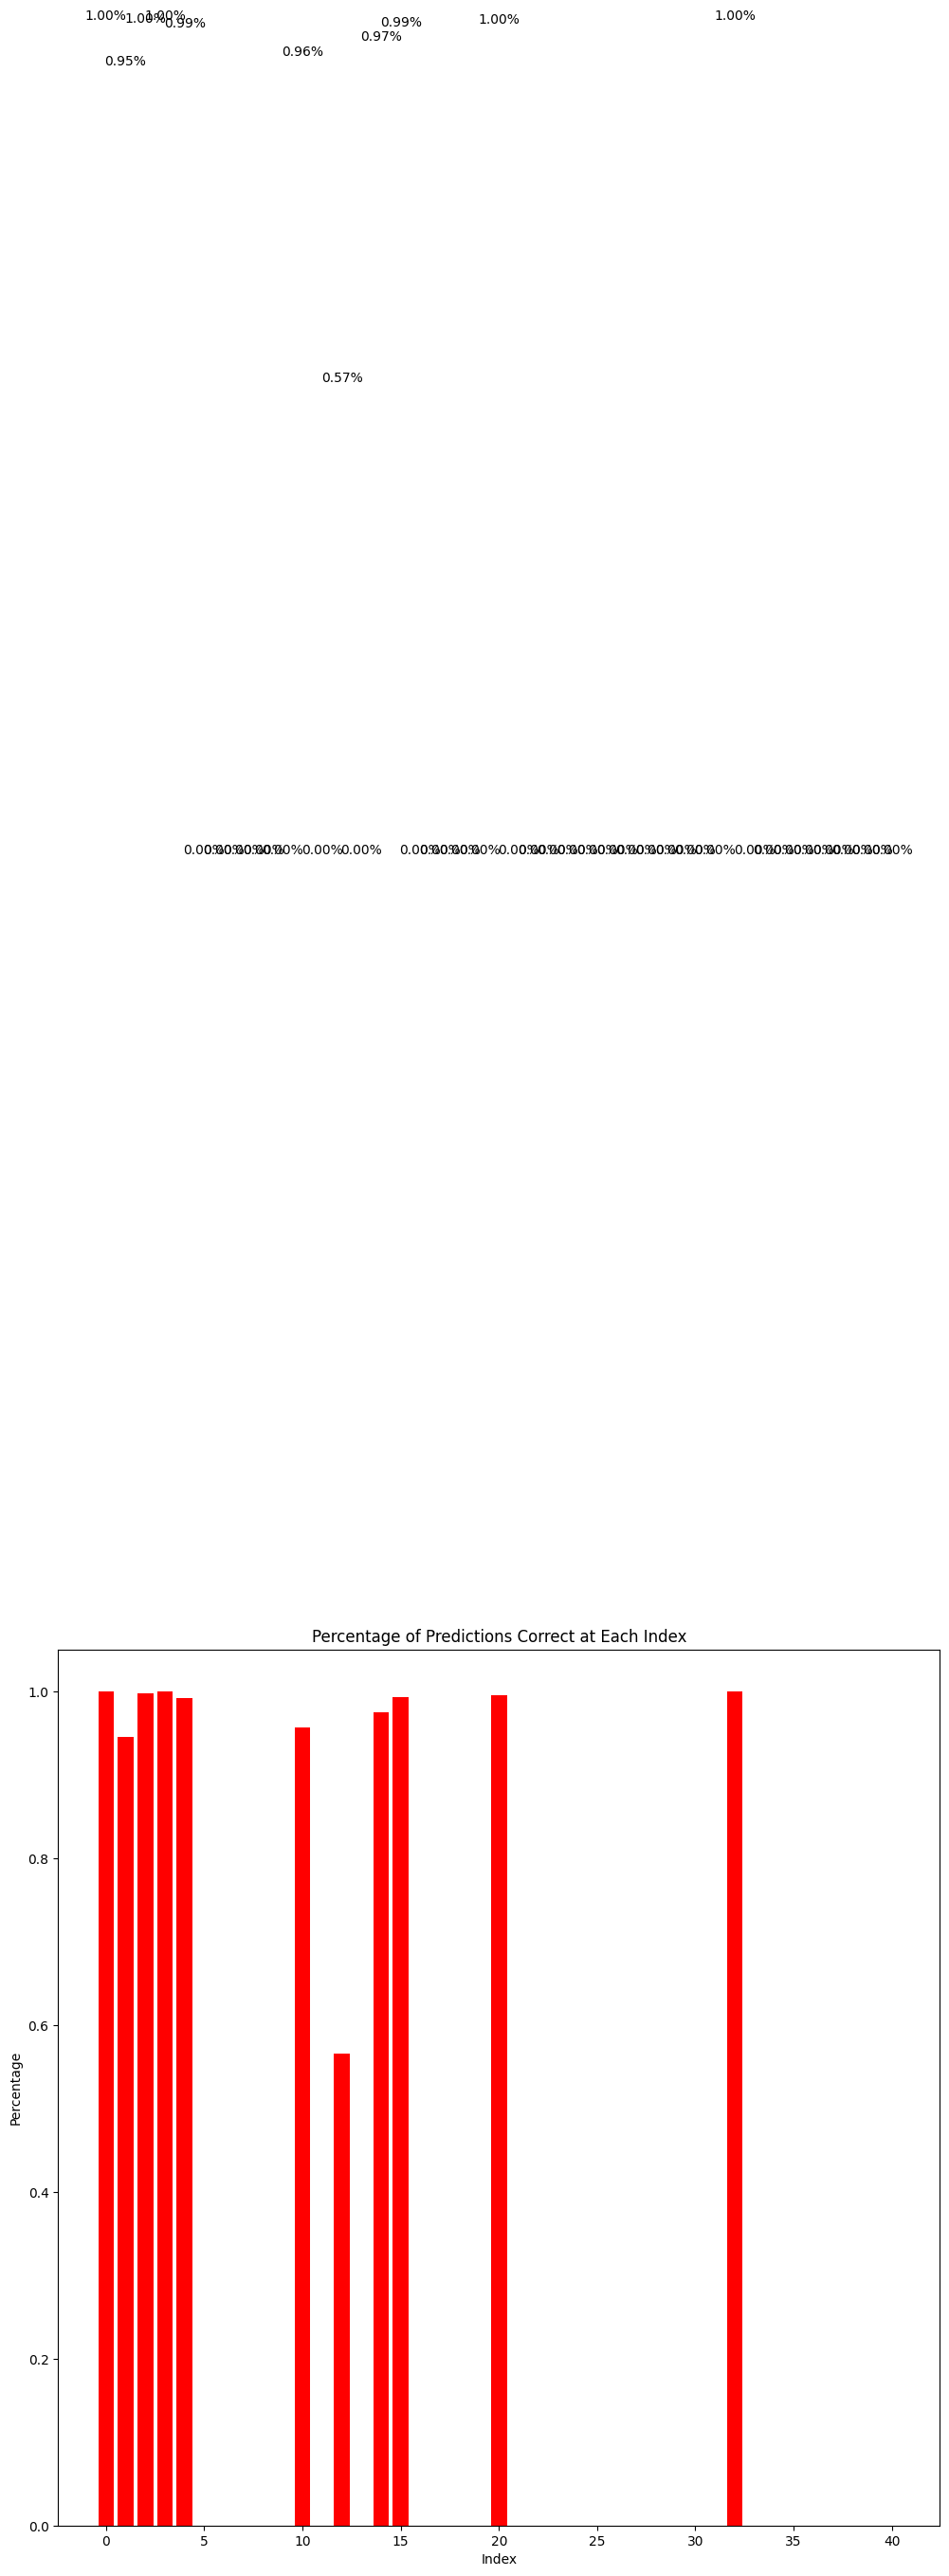

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
labels = array_sum
predictions = array_correct

# Calculate the percentage of correct predictions for each index
percentages = []
for i in range(len(labels)):
    percentage = predictions[i] * 1.0 / labels[i]
    percentages.append(percentage)

print(percentages)

# Create a bar chart for each index
fig, ax = plt.subplots(figsize=(12, 12))
# fig, ax = plt.subplots()
ax.bar(range(len(labels)), percentages, color=['green' if p == 100 else 'red' for p in percentages])
ax.set_xlabel('Index')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Predictions Correct at Each Index')

# Display the percentage on top of the bars
for i, v in enumerate(percentages):
    ax.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', color='black')
plt.show()
